# Semantic segmentation with Deep Learning
Centrale Nantes

Diana Mateus

**Participants:** Saâd Aziz Alaoui, Yassine Jamoud, Samy Haffoudhi

### Introduction

In many areas of biomedical research, cell counts obtained from images are crucial data for diagnosing patients or for addressing hypotheses about developmental or pathological processes. Although the field changes reapidly, many cell counts are still done manually or with semi-automatic tools. An automatic tool can therefore save time, reduce variability, and improve results. In this notebook we will model the problem in terms of semantic segmentation and approach it by means of deep learning, and more specifically with the U-Net architecture.

### 1. Load modules and data

#### 1.1 Import modules

In [1]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model


#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

2022-02-28 09:27:46.243180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-28 09:27:46.243210: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Python       : 3.10.2 (main, Jan 15 2022, 19:56:27) [GCC 11.1.0]
Numpy        : 1.21.5
Skimage      : 0.19.1
Scikit-learn : 1.0.1
Tensorflow   : 2.8.0-rc1


#### 1.2 Import data 
Download data from

- https://box.ec-nantes.fr/index.php/s/X84Bq5NYJ2zJRpR (small dataset to begin with)
- https://box.ec-nantes.fr/index.php/s/oXAx37DbpXPDF7T (larger dataset for final tests single zip -> good internet connection)

#### 1.3 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [2]:
#In case using colab
#from google.colab import drive

#drive.mount('/content/drive')

In [3]:
train_path = "stage1_train"#path to training data file/folder
test_path = "stage1_test" #path to test data file/folder

#### 1.4 Define global parameters
- Set seed for random values to a fix number (suggested: 42) to ensure that images are associated to the exactly corresponding masks . 
- Define the desired image size as two global parameters:
``` img_height, img_width ```. 
The defalut image size  is (64,64). You may want to reduce size for faster **debugging** or increase it (e.g. 256,256) for better results

In [4]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
#num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (128,128)  #Default to (256,266), use (None,None) if you do not want to resize imgs

#### 1.5 Read and preload the input image data
Read the data and create a tensor containing all the train and test data as well as their corresponding labels.

The following function ``get_images``  
- receives as input an image path (can be train or test), and a desired image shape for the output
- lists all files in the input image path. 
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the images according to the ``img_height, img_width`` parameters.
- uses only the first three channels of the images.
- returns a numpy array (matrix) . 
- uses ``%%time`` to display the time spent in loading.

Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 

In [5]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if id != ".DS_Store"]

    #X_data = np.array([skimage.io.imread(path)[:,:,:3] for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

X_train = get_images(train_path, output_shape=(img_height,img_width))

print(X_train.shape, X_train.dtype)
    


(50, 128, 128, 3) uint8
CPU times: user 1 s, sys: 29.7 ms, total: 1.03 s
Wall time: 1.03 s


#### 1.6 Read and preload the expert annotation masks 
The following function ``get_labels``  
- receives as input a mask path (can be train or test), and a desired image shape for the output.
- lists all files in the input path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the masks according to the ``img_height, img_width`` parameters.
- returns a numpy array (matrix) . Hint: define an ``np.array`` of type ``dtype=np.uint8`` to stock the data.
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3)) uint8 
- This can take some minutes (reduce the number of images to accelerate the first tests and reduce memory demands if necessary)

In [6]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path) if id != ".DS_Store"]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)

    # make sure to return the binary images but coded as floats to be compatible with the loss functions
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data    
    
Y_train = get_labels(train_path, output_shape=(img_height,img_width))

print("We have {} labeled images of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))




We have 50 labeled images of size (128,128) and type bool
CPU times: user 2.55 s, sys: 156 ms, total: 2.71 s
Wall time: 2.71 s


<timed exec>:16: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
Y_train =1.0*Y_train.astype(float)

#### 1.7 Visualize some examples of images and matching labels
Choose one index among the lists of images and labels and use ``plt.imshow`` to visualize side by side the corresponding image and mask.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

Looking at image  38


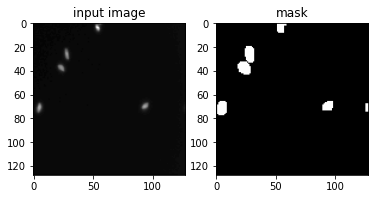

In [8]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]


print ('Looking at image ', idx)

plt.subplot(1,2,1)
plt.imshow(skimage.exposure.rescale_intensity(X_train[idx, :, :, :]))
plt.title('input image')
plt.subplot(1,2,2)
plt.imshow(Y_train[idx, :, :],cmap='gray')
plt.title('mask')

plt.show()

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

The u-net is composed of an input layer, an encoder and a decoder. Both the encoder and deconder consists of several blocks with similar structure but different dimensions. Each encoder blocks is composed of two convolutional layers of the same dimensions with a pooling and an activation function. With pooling operations, the 2D dimensions of the image are progressively reduced; to compensate the number of filters (or equivalently of feature channels) in each block is increased. The decoder reverses the operations of the encoder. Finally skip connections are created between the encoder and the decoder. To make these connections  it is useful to create a list pointing to the output of each encoder block as well as a list pointing to the output of each decoder block.

**a)** Building the model
- Create a function ```model``` that receives as input the image size 
- Start by predefining as parameters within the function
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - a global kernel size ```(3,3)```
    - a weight initialization method (try `he_normal`)
- Create an input layer using the Keras function ``Input`` , the shape should match the the image dimensions.
- Declare the encoder blocks each composed of:
    - two convolutional layers. Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - create a list pointing to each of the encoder blocks to be able to refer to them later while creating the skip connections
    - **Hint** Define one block of convolution+pool+relu then create a loop to iterate over the different blocks

- Define the decoder blocks each composed of:
    - one Transpose convolution layer.
    - two convolutional layers. 
    - use relu activations
    - create a list with pointing to each encoder blocks to be able to refer to them later the skip connections
    - **Hint** Define one block of transposed convolution+conv+relu then create a loop to iterate over the different blocks


- The output layer should be a Transpose convolution layer with a 'sigmoid' activatin and a 'glorot_normal' initialization

- Use the lists created above to create the skip connections 
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Use the keras function ``Model`` to identify this function as the architecture and use the output of ```Model``` as the return value of the unet_model function


In [9]:
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block SELON TAILLE IMAGE ! 
    #n_channels = [2**i for i in range(4,int(np.log2(img_width)+1))]
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = [] 
    
    initializer = tf.keras.initializers.HeNormal()

    
    
    # Use Keras Input layer to create one
    inp = Input(shape = (img_width,img_height,3))
    
    
    # Encoder
    conv_enc = inp
    for i in range(len(n_channels)):                           
        conv_1 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_enc)
        conv_2 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_1)
        encoder_list.append(conv_2)
        conv_enc = tf.keras.layers.MaxPool2D(pool_size=(2, 2) , strides = 2)(conv_2) 
        
    # Decoder
    conv_dec = conv_enc
    n_channels.reverse()
    for k in range(len(n_channels)):
        conv_3 = tf.keras.layers.Conv2DTranspose(n_channels[k],kernel_size = k_size, strides=2 , activation = "relu", padding='same')(conv_dec)
        decoder_list.append(conv_3)
        merge = add([conv_3, encoder_list[-k-1]])
        conv_4 = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(merge)
        conv_dec = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(conv_4)    
        
    # Output  
    outp = tf.keras.layers.Conv2DTranspose(1,kernel_size = k_size , kernel_initializer='glorot_normal',
                                           activation = "sigmoid", padding='same')(conv_dec)
    
    #outp = tf.keras.layers.Dropout(0.2)(outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

#### 2.2. Define the losses

Define and explain how to use the Dice coefficient and the binarry crossentropy as loss and metrics for the segmentation. Create a costum dice loss that is a weighted average between the two

In [10]:
def dice_coef(y_true, y_pred):
    score = 2 * (tf.math.reduce_sum(y_true * y_pred) / tf.math.reduce_sum(y_true + y_pred))
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

def costum_dice_loss(y_true, y_pred):
    loss = 0.5 * dice_loss(y_true, y_pred) + 0.5 * binary_crossentropy(y_true, y_pred)
    return loss

#### 2.3 Define the optimizer 

In [11]:
# Set optmizer, loss and metric
optimizer = "adam"
loss      = costum_dice_loss
metrics   = "accuracy"

#### 2.4 Compile the model

In [12]:
#instantiate the model

model = unet_model(img_width, img_height)

#summary
model.summary()
#compile the model
model.compile(loss = loss , optimizer = optimizer, metrics=metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  


2022-02-28 09:27:51.449420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-28 09:27:51.449480: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-28 09:27:51.449522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arch): /proc/driver/nvidia/version does not exist
2022-02-28 09:27:51.449911: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 16)   0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 32)   4640        ['max_pooling2d[0][0]']          
                                                                                                  
 conv2d_3 

                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 128, 128, 1)  145        ['conv2d_19[0][0]']              
 spose)                                                                                           
                                                                                                  
Total params: 3,733,233
Trainable params: 3,733,233
Non-trainable params: 0
__________________________________________________________________________________________________


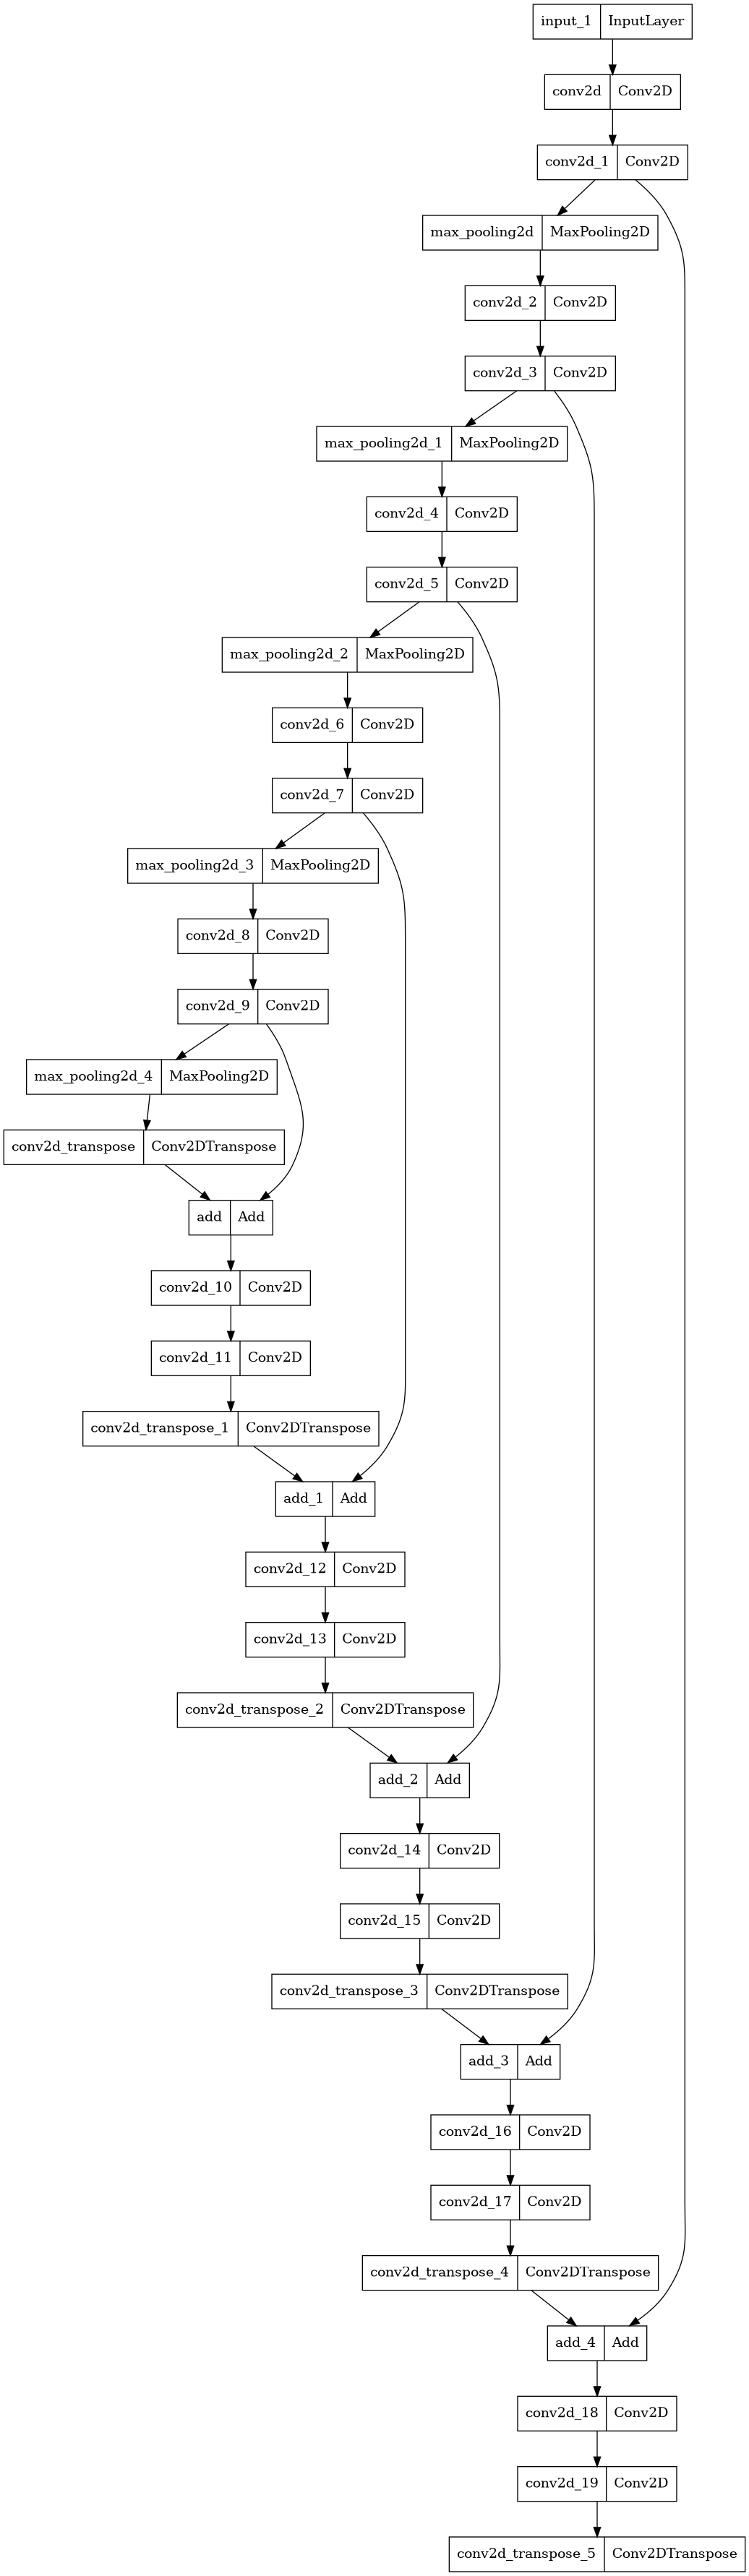

In [13]:
#run the following cell to visualize the created model

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### 3. Trainning and testing

#### 3.1 Launch the training
- Use the ```model.fit``` function to launc the training, 
- save the output of the model.fit which provides the history of the training results. 
- Measure the overall time with ```%%time``` at the beginning of the notebook cell


In [14]:
%%time
# Fit model
epochs = 25

batch_size = 25

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/25
2/2 [==============================] - 3s 1s/step - loss: 2.3319 - accuracy: 0.4596
Epoch 2/25
2/2 [==============================] - 2s 1s/step - loss: 1.9393 - accuracy: 0.7624
Epoch 3/25
2/2 [==============================] - 2s 1s/step - loss: 1.3824 - accuracy: 0.7539
Epoch 4/25
2/2 [==============================] - 2s 1s/step - loss: 1.0124 - accuracy: 0.3219
Epoch 5/25
2/2 [==============================] - 2s 1s/step - loss: 0.8812 - accuracy: 0.5151
Epoch 6/25
2/2 [==============================] - 2s 1s/step - loss: 0.8662 - accuracy: 0.7572
Epoch 7/25
2/2 [==============================] - 2s 1s/step - loss: 0.7752 - accuracy: 0.7692
Epoch 8/25
2/2 [==============================] - 2s 1s/step - loss: 0.7236 - accuracy: 0.6977
Epoch 9/25
2/2 [==============================] - 2s 1s/step - loss: 0.6597 - accuracy: 0.7717
Epoch 10/25
2/2 [==============================] - 2s 1s/step - loss: 0.6257 - accuracy: 0.7985
Epoch 11/25
2/2 [==============================] 

In [15]:
score = model.evaluate(X_train, Y_train, verbose=0)
print("Train accuracy:", score[1])

Train accuracy: 0.9150793552398682


#### 3.2. Save the model
Save the final model ``model_out.save_weights`` with an hdf5 format. 

In [16]:
model.save_weights('model1_weights.hdf5')

#### 3.3. Plot the loss and the metrics

from the output of the fit function

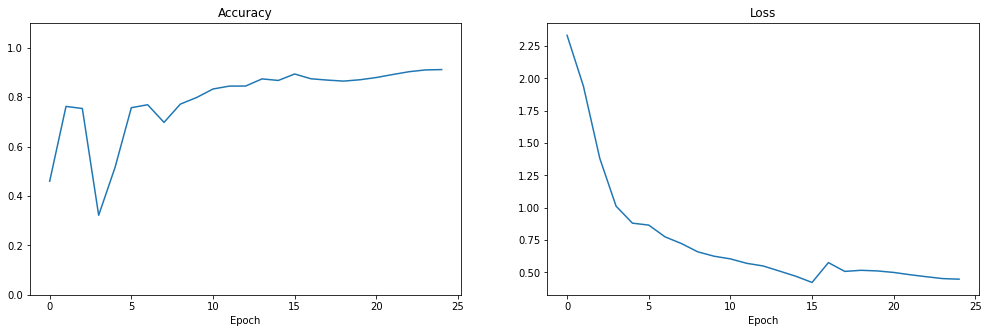

In [17]:
plt.figure(figsize=(17,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1.1])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

#### 3.4. Test
Load the test images, make predictions and visualize the predictions 



In [18]:
X_test = get_images(test_path, output_shape=(img_height,img_width))
print(X_test.shape, X_test.dtype)

(10, 128, 128, 3) uint8


In [19]:
# if required reload the model
model.load_weights('model1_weights.hdf5')

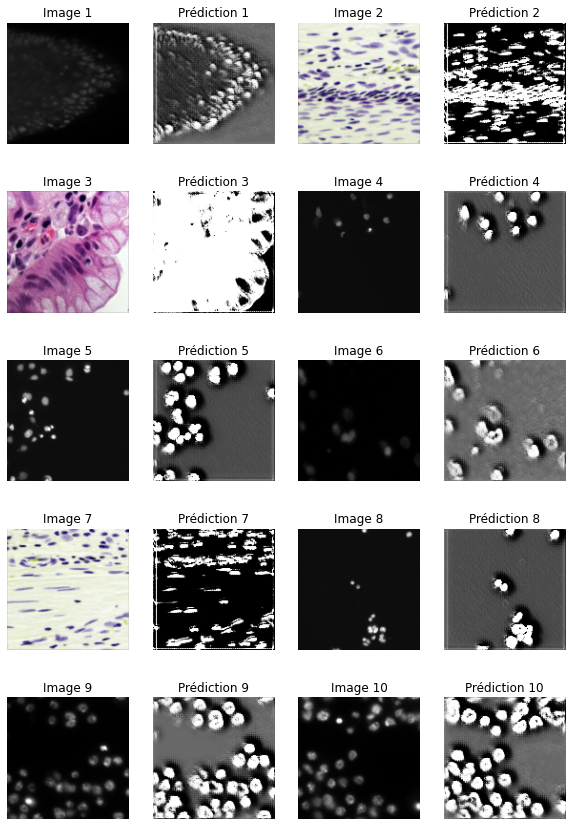

In [20]:
plt.figure(figsize=(10,15))

prediction = model.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(5, 4, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'Prédiction {i+1}')
    plt.axis('off')
    
    plt_counter += 2

plt.show()

### 4 Comparison and Improvement

Try making changes to improve the results. Do at least one of the following modifications 
- Change the architecture (use the one from the tf example, or add other types of layers (e.g. dropout) or non-linarities (e.g. leaky relu) and compare the training curves
- add data augmentation (rotation, flip, translation of each image)
- add an explicit validation set and ilustrate the intermediate results and metrics on the validation set
- add data generators (to sample and augment data online)





In [21]:
def unet_model_enhanced(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block SELON TAILLE IMAGE ! 
    #n_channels = [2**i for i in range(4,int(np.log2(img_width)+1))]
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = [] 
    
    initializer = tf.keras.initializers.HeNormal()

    
    
    # Use Keras Input layer to create one
    inp = Input(shape = (img_width,img_height,3))
    
    # Encoder
    conv_enc = inp
    for i in range(len(n_channels)):                           
        conv_1 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_enc)
        conv_2 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_1)
        encoder_list.append(conv_2)
        conv_enc = tf.keras.layers.MaxPool2D(pool_size=(2, 2) , strides = 2)(conv_2) 
        
    # Decoder
    conv_dec = conv_enc
    n_channels.reverse()
    for k in range(len(n_channels)):
        conv_3 = tf.keras.layers.Conv2DTranspose(n_channels[k],kernel_size = k_size, strides=2 , activation = "relu", padding='same')(conv_dec)
        decoder_list.append(conv_3)
        merge = add([conv_3, encoder_list[-k-1]])
        conv_4 = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(merge)
        conv_dec = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(conv_4)    
        
    # Output  
    outp = tf.keras.layers.Conv2DTranspose(1,kernel_size = k_size , kernel_initializer='glorot_normal',
                                           activation = "sigmoid", padding='same')(conv_dec)
    
    #outp = tf.keras.layers.Dropout(0.2)(outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [22]:
#instantiate the model

model_enhanced = unet_model_enhanced(img_width, img_height)

#summary
model_enhanced.summary()
#compile the model
model_enhanced.compile(loss = loss , optimizer = optimizer, metrics=metrics)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_20[0][0]']              
                                )                                                           

                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  2320        ['add_9[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_38[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 128, 128, 1)  145        ['conv2d_39[0][0]']              
 nspose)                                                                                          
                                                                                                  
Total para

In [47]:
epochs = 25
batch_size = 25

In [48]:
def data_augmentation(X, Y, validation_split=0.1, seed=seed, batch_size=batch_size):
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, 
                                                      Y, 
                                                      train_size =1-validation_split, 
                                                      test_size=validation_split, 
                                                      random_state=seed)
    
    data_gen_args = dict(rotation_range = 45.,
                     width_shift_range = 0.1,
                     height_shift_range = 0.1,
                     horizontal_flip = True,
                     vertical_flip = True)

    X_datagen = ImageDataGenerator(**data_gen_args)
    y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    y_datagen.fit(Y_train, augment=True, seed=seed)
    X_augmented_train = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_augmented_train = y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
    
    X_datagen_val = ImageDataGenerator()
    y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_val, augment=True, seed=seed)
    y_datagen_val.fit(Y_val, augment=True, seed=seed)
    X_augmented_val = X_datagen_val.flow(X_val, batch_size=batch_size, shuffle=True, seed=seed)
    Y_augmented_val = y_datagen_val.flow(Y_val, batch_size=batch_size, shuffle=True, seed=seed)

    return zip(X_augmented_train, Y_augmented_train), zip(X_augmented_val, Y_augmented_val)

train_gen, val_gen = data_augmentation(X_train, Y_train)

In [50]:
%%time

# Fit model
history_enhanced = model_enhanced.fit(train_gen, 
                                      epochs=epochs, 
                                      validation_data=val_gen,
                                      validation_steps=batch_size,
                                      steps_per_epoch=len(X_train)//batch_size)

Epoch 1/25
2/2 [==============================] - 3s 2s/step - loss: 0.1969 - accuracy: 0.8976 - val_loss: 0.2745 - val_accuracy: 0.9023
Epoch 2/25
2/2 [==============================] - 3s 2s/step - loss: 0.1923 - accuracy: 0.8994 - val_loss: 0.2756 - val_accuracy: 0.9018
Epoch 3/25
2/2 [==============================] - 3s 2s/step - loss: 0.1888 - accuracy: 0.8992 - val_loss: 0.2788 - val_accuracy: 0.9006
Epoch 4/25
2/2 [==============================] - 3s 2s/step - loss: 0.1827 - accuracy: 0.9009 - val_loss: 0.2644 - val_accuracy: 0.9044
Epoch 5/25
2/2 [==============================] - 3s 2s/step - loss: 0.1826 - accuracy: 0.9020 - val_loss: 0.2587 - val_accuracy: 0.9080
Epoch 6/25
2/2 [==============================] - 3s 2s/step - loss: 0.1783 - accuracy: 0.9022 - val_loss: 0.2747 - val_accuracy: 0.9052
Epoch 7/25
2/2 [==============================] - 3s 2s/step - loss: 0.1819 - accuracy: 0.9020 - val_loss: 0.2576 - val_accuracy: 0.9111
Epoch 8/25
2/2 [=========================

In [51]:
score = model_enhanced.evaluate(X_train, Y_train, verbose=0)
print("Train accuracy:", score[1])

Train accuracy: 0.9468896389007568


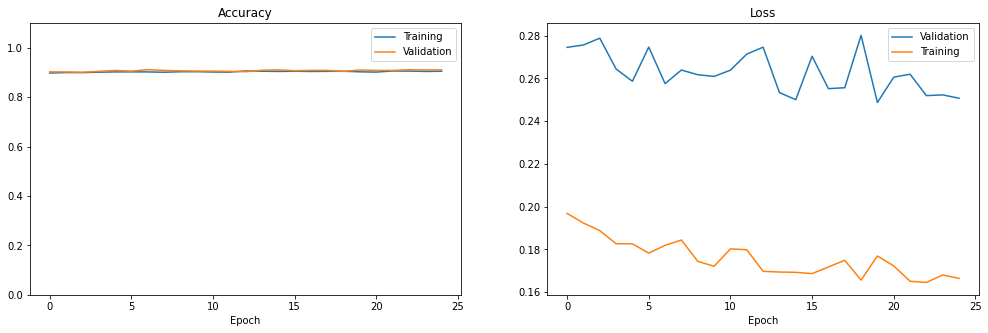

In [52]:
plt.figure(figsize=(17,5))

plt.subplot(1, 2, 1)
plt.plot(history_enhanced.history['accuracy'], label='Training')
plt.plot(history_enhanced.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1.1])

plt.subplot(1, 2, 2)
plt.plot(history_enhanced.history['val_loss'], label='Validation')
plt.plot(history_enhanced.history['loss'], label='Training')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

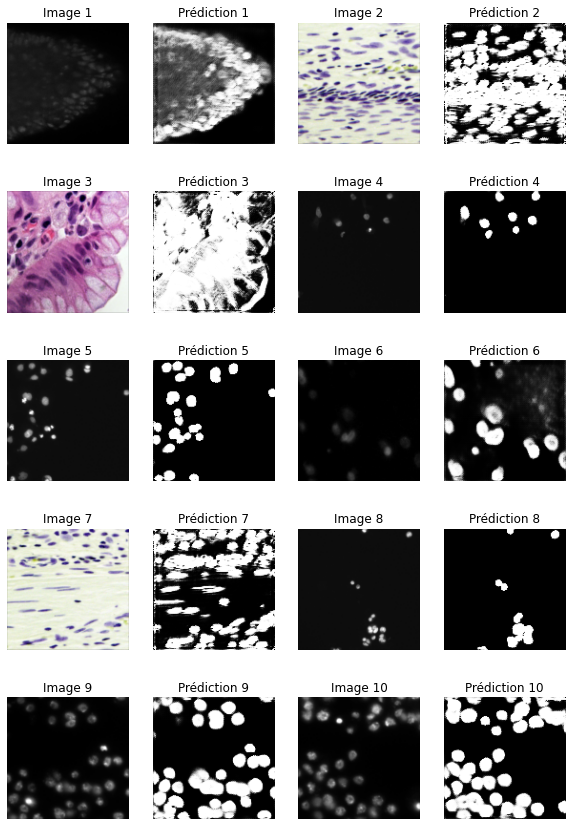

In [53]:
plt.figure(figsize=(10,15))

prediction = model_enhanced.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(5, 4, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(5, 4, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'Prédiction {i+1}')
    plt.axis('off')
    
    plt_counter += 2

plt.show()

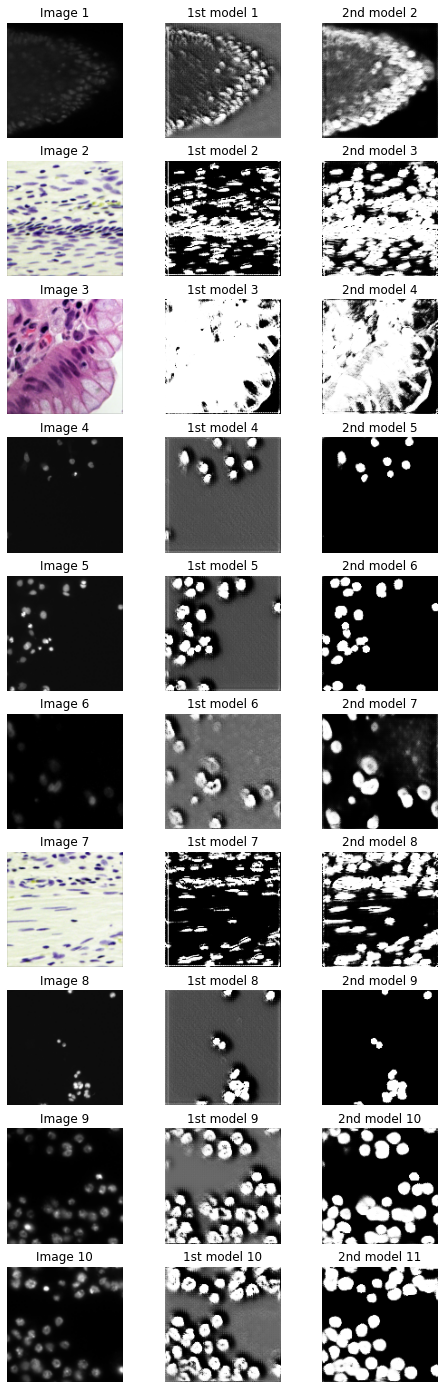

In [58]:
plt.figure(figsize=(8,25))

prediction_enhanced = model_enhanced.predict(X_test)
prediction = model.predict(X_test)

plt_counter = 1

for i in range(X_test.shape[0]):
    plt.subplot(10, 3, plt_counter)
    plt.imshow(X_test[i])
    plt.title(f'Image {i+1}')
    plt.axis('off')
    
    plt.subplot(10, 3, plt_counter + 1)
    plt.imshow(prediction[i], cmap='gray')
    plt.title(f'1st model {i+1}')
    plt.axis('off')
    
    plt.subplot(10, 3, plt_counter + 2)
    plt.imshow(prediction_enhanced[i], cmap='gray')
    plt.title(f'2nd model {i+2}')
    plt.axis('off')
    
    plt_counter += 3

plt.show()